# Register Hunmingbird Environments

In [6]:
import unity_env_wrapper
unity_env_wrapper.get_all_ids()

Available Hummingbird Environments:
 HumMultiagent
 HumMultiagentNovisual
 HumSingleagent
 HumSingleAgentNovisual
 BirdSingleAgentNoStacked
 BirdSingleAgentNoStackedNoVisual


# Simple Training

In [15]:
import gym

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv

# Set a model id for saving
model_id = "sb_ppo_HumSingleNoStacked"

# Create environment
# env = gym.make("BirdSingleAgentNoStacked-v1")
env = DummyVecEnv([lambda: gym.make("BirdSingleAgentNoStacked-v1")])

# Instantiate the agent
model = PPO("MlpPolicy", env, verbose=1) # model = DQN('MlpPolicy', env, learning_rate=1e-3, prioritized_replay=True, verbose=1)
# Train the agent
model.learn(total_timesteps=int(2e3))
# Save the agent
model.save(model_id)
del model  # delete trained model to demonstrate loading

# Load the trained agent
model = PPO.load(model_id)

# Evaluate the agent
mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

# Enjoy trained agent
obs = env.reset()
for i in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

[INFO] Connected to Unity environment with package version 2.0.0-exp.1 and communication version 1.5.0
[INFO] Connected new brain: Hummingbird?team=0
[WARNING] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.
Using cuda device
-----------------------------------------
| time/                   |             |
|    fps                  | 96          |
|    iterations           | 1           |
|    time_elapsed         | 21          |
|    total_timesteps      | 2048        |
| train/                  |             |
|    approx_kl            | 0.005760595 |
|    clip_fraction        | 0.128       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.87       |
|    explained_variance   | 0.0671      |
|    learning_rate        | 0.0003      |
|    loss                 

AttributeError: 'NoneType' object has no attribute 'reset'

In [16]:
env.close()

# Vectorized Training

In [12]:
import gym
import numpy as np

from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

def make_env(env_id, rank, seed=0):
    """
    Utility function for multiprocessed env.

    :param env_id: (str) the environment ID
    :param num_env: (int) the number of environments you wish to have in subprocesses
    :param seed: (int) the inital seed for RNG
    :param rank: (int) index of the subprocess
    """
    def _init():
        env = gym.make(env_id)
        env.seed(seed + rank)
        return env
    set_random_seed(seed)
    return _init

def main():
#     env_id = "CartPole-v1"
    env_id = "BirdSingleAgentNoStackedNoVisual-v1"
    model_id = "sb_ppo_HumSingleNoStacked_vectorized"

    num_cpu = 1  # Number of processes to use
    # Create the vectorized environment
    env = SubprocVecEnv([make_env(env_id, i) for i in range(num_cpu)])

    model = PPO('MlpPolicy', env, verbose=1)
    model.learn(total_timesteps=25000)
    
    # Save the agent
    model.save(model_id)
    del model  # delete trained model to demonstrate loading

    # Load the trained agent
    model = PPO.load(model_id)

    # Evaluate the agent
    mean_reward, std_reward = evaluate_policy(model, model.get_env(), n_eval_episodes=10)

    # Enjoy trained agent
    obs = env.reset()
    for i in range(1000):
        action, _states = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        env.render()

if __name__ == '__main__':
    main()

ValueError: not enough values to unpack (expected 2, got 0)

# Monitoring Training

[INFO] Connected to Unity environment with package version 2.0.0-exp.1 and communication version 1.5.0
[INFO] Connected new brain: Hummingbird?team=0
[WARNING] The environment contains multiple observations. You must define allow_multiple_obs=True to receive them all. Otherwise, only the first visual observation (or vector observation ifthere are no visual observations) will be provided in the observation.
Using cuda device
Wrapping the env in a DummyVecEnv.
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 0.00
Saving new best model to tmp/best_model
Num timesteps: 2000
Best mean reward: 0.00 - Last mean reward per episode: 483.56
Saving new best model to tmp/best_model
Num timesteps: 3000
Best mean reward: 483.56 - Last mean reward per episode: 677.71
Saving new best model to tmp/best_model
Num timesteps: 4000
Best mean reward: 677.71 - Last mean reward per episode: 508.28
Num timesteps: 5000
Best mean reward: 677.71 - Last mean reward per episode: 477.07
Num

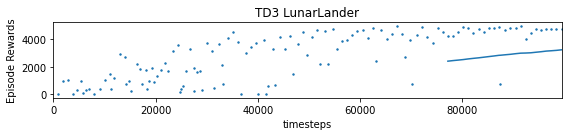

In [79]:
import os

import gym
import numpy as np
import matplotlib.pyplot as plt

# from stable_baselines3 import TD3
from stable_baselines3 import PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise



# -----------------
try:
    unity_env.close()
    env.close()
except:
    pass
# -----------------

# Create log dir
log_dir = "tmp/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
# env = gym.make('LunarLanderContinuous-v2')
unity_env = UnityEnvironment(file_name="../run32_nostacked/run32_nostacked")
env = UnityToGymWrapper(unity_env, uint8_visual=False, allow_multiple_obs=False)
env = Monitor(env, log_dir)

env = gym.make("BirdSingleAgentNoStacked-v1")


# Add some action noise for exploration
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Because we use parameter noise, we should use a MlpPolicy with layer normalization
model = PPO('MlpPolicy', env, verbose=1)
# model = TD3('MlpPolicy', env, action_noise=action_noise, verbose=0)

# Define Timesteps
timesteps = 1e5
# Create the callback
callback = SaveOnBestTrainingRewardCallback(check_freq=int(timesteps/5), log_dir=log_dir)
# Train the agent
model.learn(total_timesteps=int(timesteps), callback=callback)

plot_results([log_dir], timesteps, results_plotter.X_TIMESTEPS, "TD3 LunarLander")
plt.show()

In [76]:
!pip install stable-baselines[mpi]


     |████████████████████████████████| 240 kB 5.6 MB/s eta 0:00:01


In [58]:
import gym
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import VecMonitor, VecVideoRecorder, DummyVecEnv
env = DummyVecEnv([lambda: gym.make("HumSingleagent-v1")])


ImportError: cannot import name 'VecMonitor' from 'stable_baselines3.common.vec_env' (/home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/vec_env/__init__.py)

In [22]:
!ls /home/ros/.local/lib/python3.8/site-packages/stable_baselines3/common/vec_env/

__init__.py	 dummy_vec_env.py     util.py		  vec_normalize.py
__pycache__	 obs_dict_wrapper.py  vec_check_nan.py	  vec_transpose.py
base_vec_env.py  subproc_vec_env.py   vec_frame_stack.py  vec_video_recorder.py
